# 权重衰退

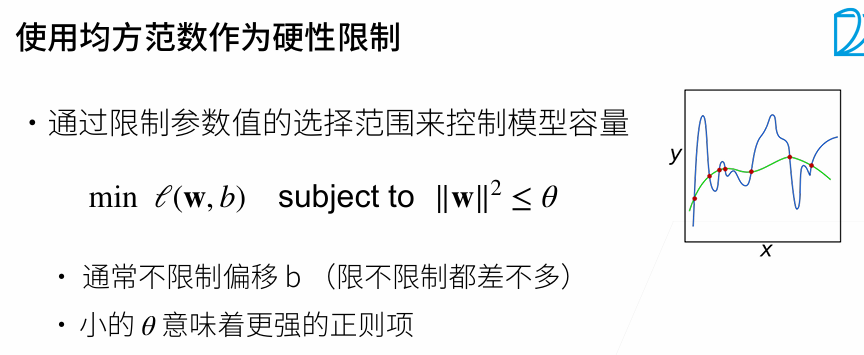

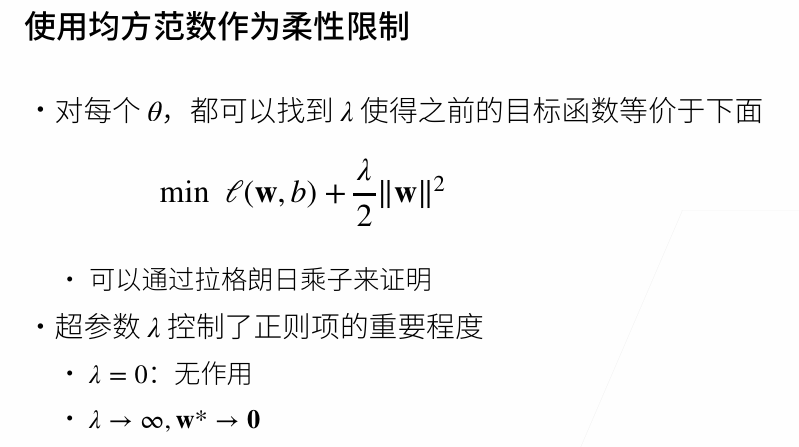

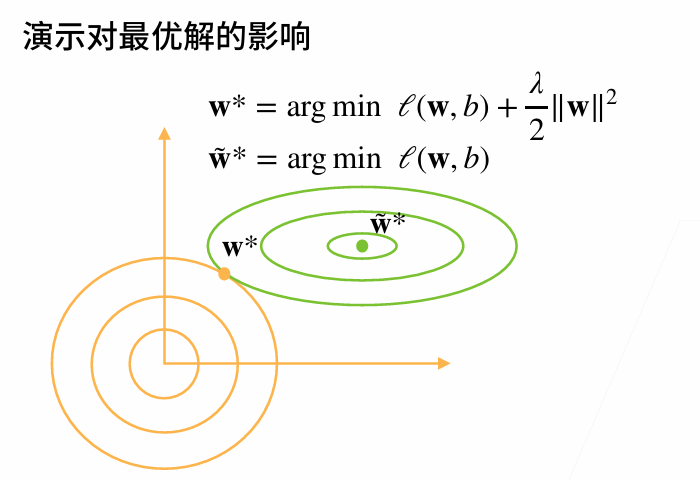

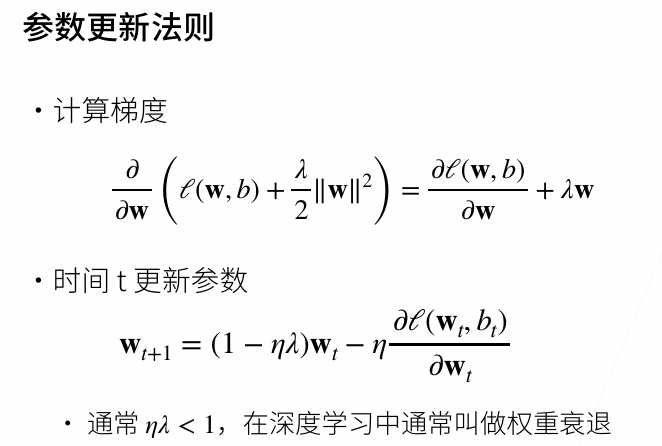

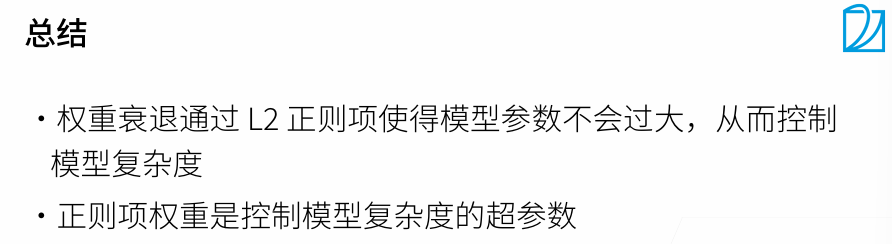

## 高维线性回归

用一个简单的例子来演示权重衰减

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

首先，按以下公式生成数据:

$$
y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).
$$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

### 初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义$L_2$范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 定义训练代码实现

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 忽略正则化直接训练

w的L2范数是： 13.280783653259277


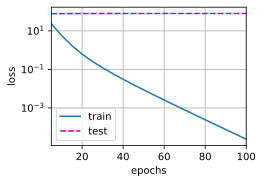

In [6]:
train(lambd=0)

### 使用权重衰减

w的L2范数是： 0.40327101945877075


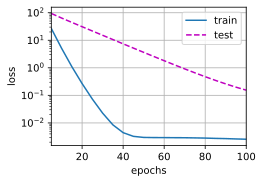

In [8]:
train(lambd=3)

## 简洁实现

由于权重衰减在神经网络优化中很常用， 深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中，以便与任何损失函数结合使用。 此外，这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。 由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过weight_decay指定weight decay超参数。 默认情况下，PyTorch同时衰减权重和偏移。 这里我们只为权重设置了weight_decay，所以偏置参数
不会衰减。

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.297982215881348


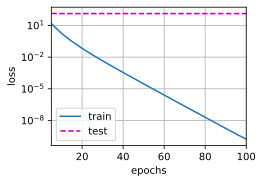

In [10]:
train_concise(0)

这些图看起来和我们从零开始实现权重衰减时的图相同。 然而，它们运行得更快，更容易实现。 对于更复杂的问题，这一好处将变得更加明显。

w的L2范数： 0.42380139231681824


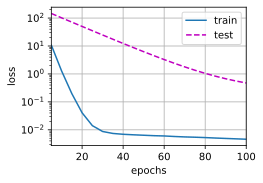

In [11]:
train_concise(3)

## 小结

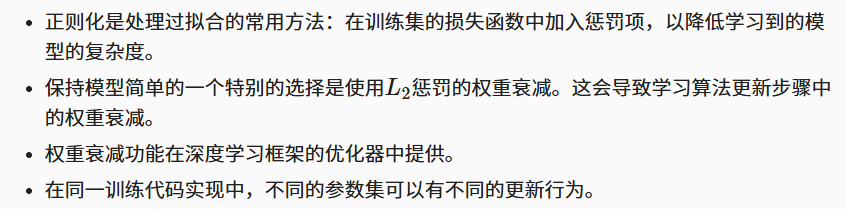